<a href="https://colab.research.google.com/github/pradhapmoorthi/P1_Facial_Keypoints/blob/MediumNet/2.%20Define%20the%20Network%20Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [ ]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
#%load_ext autoreload
#%autoreload 2

In [ ]:
get_ipython().system('rm -f models.py models.py.*')
get_ipython().system('wget https://raw.githubusercontent.com/pradhapmoorthi/P1_Facial_Keypoints/MediumNet/models.py')

--2026-01-01 13:43:56--  https://raw.githubusercontent.com/pradhapmoorthi/P1_Facial_Keypoints/MediumNet/models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8805 (8.6K) [text/plain]
Saving to: ‘models.py’

models.py           100%[===================>]   8.60K  --.-KB/s    in 0.001s  

2026-01-01 13:43:56 (14.3 MB/s) - ‘models.py’ saved [8805/8805]



In [ ]:
from models import Net

net = Net()
print(net)

MediumNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (FC1): Linear(in_features=50176, out_features=2048, bias=True)
  (FC2): Linear(in_features=2048, out_features=1024, bias=True)
  (FC3): Linear(in_features=1024, out_features=136, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.1, inplace=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (drop4): Dropout(p=0.4, inplace=False)
  (drop5): Dropout(p=0.5, inplace=False)
  (drop6): Dropout(p=0.6, inplace=False)
)


In [ ]:
import os


from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


## Transform the dataset

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [ ]:
get_ipython().system('wget https://raw.githubusercontent.com/pradhapmoorthi/P1_Facial_Keypoints/master/models.py')
get_ipython().system('wget https://raw.githubusercontent.com/pradhapmoorthi/P1_Facial_Keypoints/master/data_load.py')

--2026-01-01 13:44:23--  https://raw.githubusercontent.com/pradhapmoorthi/P1_Facial_Keypoints/master/models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9503 (9.3K) [text/plain]
Saving to: ‘models.py.1’

models.py.1         100%[===================>]   9.28K  --.-KB/s    in 0.001s  

2026-01-01 13:44:23 (9.78 MB/s) - ‘models.py.1’ saved [9503/9503]

--2026-01-01 13:44:23--  https://raw.githubusercontent.com/pradhapmoorthi/P1_Facial_Keypoints/master/data_load.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4835 (4.7K) [tex

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250), RandomCrop(224), Normalize(), ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [ ]:
# Prepare data directories and download data
get_ipython().system('mkdir -p data')
get_ipython().system('wget https://github.com/pradhapmoorthi/P1_Facial_Keypoints/archive/master.zip -O P1_Facial_Keypoints-master.zip')
get_ipython().system('unzip P1_Facial_Keypoints-master.zip')
get_ipython().system('mv P1_Facial_Keypoints-master/data/training data/')
get_ipython().system('mv P1_Facial_Keypoints-master/data/test data/')
get_ipython().system('rm P1_Facial_Keypoints-master.zip')
get_ipython().system('rm -r P1_Facial_Keypoints-master')
get_ipython().system('wget -P data/ https://raw.githubusercontent.com/pradhapmoorthi/P1_Facial_Keypoints/master/data/training_frames_keypoints.csv')
get_ipython().system('wget -P data/ https://raw.githubusercontent.com/pradhapmoorthi/P1_Facial_Keypoints/master/data/test_frames_keypoints.csv')





Streaming output truncated to the last 5000 lines.
 extracting: P1_Facial_Keypoints-master/data/test/Emmy_Rossum_21.jpg  
 extracting: P1_Facial_Keypoints-master/data/test/Emmy_Rossum_30.jpg  
 extracting: P1_Facial_Keypoints-master/data/test/Emmy_Rossum_31.jpg  
 extracting: P1_Facial_Keypoints-master/data/test/Emmy_Rossum_40.jpg  
 extracting: P1_Facial_Keypoints-master/data/test/Emmy_Rossum_41.jpg  
  inflating: P1_Facial_Keypoints-master/data/test/Emmy_Rossum_50.jpg  
  inflating: P1_Facial_Keypoints-master/data/test/Emmy_Rossum_51.jpg  
 extracting: P1_Facial_Keypoints-master/data/test/Eric_Benet_00.jpg  
 extracting: P1_Facial_Keypoints-master/data/test/Eric_Benet_01.jpg  
 extracting: P1_Facial_Keypoints-master/data/test/Eric_Benet_10.jpg  
 extracting: P1_Facial_Keypoints-master/data/test/Eric_Benet_11.jpg  
 extracting: P1_Facial_Keypoints-master/data/test/Eric_Benet_30.jpg  
 extracting: P1_Facial_Keypoints-master/data/test/Eric_Benet_31.jpg  
 extracting: P1_Facial_Keypoints

In [ ]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [ ]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range.

In [ ]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [ ]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [ ]:
# test the model on a batch of test images
import torch

def net_sample_output():

    # iterate through the test dataset
    for i, sample in enumerate(test_loader):

        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)

        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)

        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [ ]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [ ]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

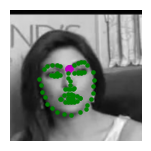

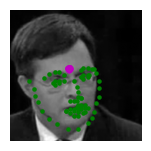

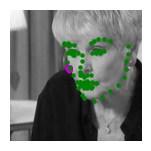

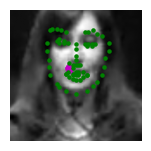

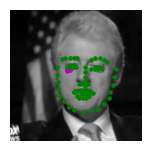

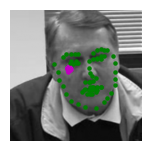

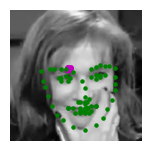

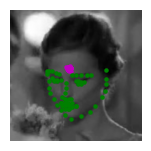

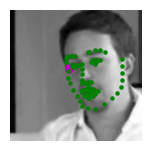

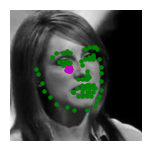

In [ ]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints
        predicted_key_pts = predicted_key_pts*50.0+100

        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]
            ground_truth_pts = ground_truth_pts*50.0+100

        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)

        plt.axis('off')

    plt.show()

# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](https://pytorch.org/docs/master/nn.html#loss-functions).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [ ]:
## TODO: Define the loss and optimization
import torch.optim as optim
import torch.nn as nn # Added import for torch.nn

criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs.

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc.

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [ ]:
import math

def calculate_rmse(output_pts, key_pts):
    """Calculates the Root Mean Square Error."""
    # Reshape key_pts to match output_pts if necessary (N, 68, 2) vs (N, 136)
    if key_pts.dim() == 2:
        key_pts_reshaped = key_pts.view(key_pts.size(0), 68, 2)
    else:
        key_pts_reshaped = key_pts

    if output_pts.dim() == 2:
        output_pts_reshaped = output_pts.view(output_pts.size(0), 68, 2)
    else:
        output_pts_reshaped = output_pts

    squared_diff = (output_pts_reshaped - key_pts_reshaped)**2
    mse_per_keypoint = torch.mean(squared_diff, dim=2) # mean over x,y coordinates
    # Calculate mean over all keypoints and batch items
    mean_mse = torch.mean(mse_per_keypoint)
    rmse = torch.sqrt(mean_mse)
    return rmse.item()

def calculate_pck(output_pts, key_pts, threshold_percentage=0.05):
    """Calculates the Percentage of Correct Keypoints (PCK).
    A keypoint is considered 'correct' if the Euclidean distance between
    the predicted and ground truth keypoint is less than a certain threshold.
    The threshold is defined as a percentage of the image diagonal.
    """
    if key_pts.dim() == 2:
        key_pts_reshaped = key_pts.view(key_pts.size(0), 68, 2)
    else:
        key_pts_reshaped = key_pts

    if output_pts.dim() == 2:
        output_pts_reshaped = output_pts.view(output_pts.size(0), 68, 2)
    else:
        output_pts_reshaped = output_pts

    # Assuming image size is 224x224 (after Rescale and RandomCrop)
    # The keypoints are normalized to [-1, 1] range. The actual coordinates
    # before normalization would be roughly [0, 224] for a 224x224 image.
    # So, the range is 2 units in normalized space for a dimension.
    # Diagonal length in normalized space for a 224x224 image (if normalized based on 100 max range) would be sqrt((100*2)^2 + (100*2)^2)
    # If original image is 224x224 and keypoints are normalized to [-1,1] from [0,224], then max range is 2.0.
    # So, we should base the threshold on the normalized range, e.g., 2.0*sqrt(2) is the max diagonal.
    # Let's consider the keypoints are scaled by 50 and shifted by 100 when denormalized.
    # So, the keypoints range from ~0 to 200.
    # The actual image size is 224x224, but the keypoints are scaled.
    # A more robust way: use the max extent of ground truth keypoints in the batch as reference.

    # For normalized keypoints [-1, 1], the overall range for x and y is 2.
    # The 'diagonal' of this normalized space is sqrt(2^2 + 2^2) = sqrt(8) approx 2.828.
    # Let's use a simpler scaling factor, assuming keypoints are within a 2x2 square centered at origin.
    # Or, perhaps better, relate it to the typical facial structure. The average 'eye-to-eye' distance is often used.
    # For now, let's use a simple scalar proportional to the normalized space. A threshold of 0.05 means 5% of the range.

    # Calculating the typical face size in normalized keypoint space for reference
    # Max distance between any two keypoints in the ground truth for scaling.
    # For the dataset, keypoints are typically within a range of approx 150-200 units (pixels) before normalization.
    # After normalization and scaling back (x*50+100), the image is 224x224. Max keypoint range is roughly 200 units.
    # The diagonal of a 200x200 pixel region is sqrt(200^2 + 200^2) = 200 * sqrt(2) approx 282.
    # A threshold_percentage of 0.05 on this would be 0.05 * 282 = 14.1 pixels.

    # Let's work with the un-normalized keypoints for PCK thresholding for clarity if we have that information.
    # However, since we are working with normalized keypoints in the model output, it's better to define threshold in normalized space.
    # The `Normalize()` transform scales keypoints to [-1, 1]. So max span is 2 units. A reasonable threshold would be percentage of this span.

    # Let's assume normalized keypoints span roughly 2 units in both x and y.
    # The 'max extent' of the keypoints might be better defined based on face size.
    # A common approach for PCK is to use a fraction of the bounding box diagonal or inter-ocular distance.
    # For this project, a simple approach is to use a threshold relative to the normalized image coordinates.
    # Let's consider the keypoints are normalized to roughly -1 to 1. The maximum possible distance between any two keypoints
    # could be approximated by the diagonal of the [-1,1] x [-1,1] box, which is sqrt((1 - (-1))^2 + (1 - (-1))^2) = sqrt(2^2 + 2^2) = sqrt(8) ~ 2.828.
    # A threshold_percentage of this span would be `threshold_percentage * 2.0` (as 2.0 is the typical span of normalized coords).

    # A typical threshold for PCK on normalized keypoints might be a fixed small value, e.g., 0.1 or 0.05 in the [-1,1] range.
    # For consistency with the display logic (keypoints * 50.0 + 100), let's consider the keypoints are effectively within a ~200x200 pixel space.
    # The `Rescale(250)` and `RandomCrop(224)` means the image is 224x224. Keypoints are scaled based on this.
    # The `Normalize()` step scales keypoints to [-1, 1]. So the "unit" distance in this space means 50 pixels in original space.

    # A common threshold for PCK is based on a fraction of the head size or inter-ocular distance.
    # Since we don't have head size readily available, let's use a fixed threshold related to the normalized coordinate system.
    # If normalized keypoints are [-1, 1], the total span is 2. So threshold = threshold_percentage * 2.
    # For example, if threshold_percentage=0.05, then threshold = 0.1.

    # The dataset uses a threshold related to the face size for PCK (often inter-eye distance or face bounding box diagonal).
    # Given the output keypoints are normalized, defining a fixed threshold in this space is crucial.
    # Let's define it such that it corresponds to a few pixels in the un-normalized image.
    # If the range of normalized coordinates is ~2, then 0.05 * 2 = 0.1 normalized unit.
    # This corresponds to 0.1 * 50 = 5 pixels in the original image scale before cropping (if max_value was 1, then 1*50=50).
    # Let's stick to using the `threshold_percentage` directly on the normalized range span.

    # Threshold based on the span of normalized keypoints (e.g., max(key_pts_reshaped) - min(key_pts_reshaped))
    # For normalized points in [-1, 1], the span is approximately 2.
    # So, the threshold can be defined as `threshold_percentage * (max_coord - min_coord)` where max_coord - min_coord = 2
    # threshold = threshold_percentage * 2
    # A common value for PCK is a threshold of 0.1 times the diagonal of the bounding box of the face.
    # Since the keypoints are scaled, let's consider the scale factor of 50.0 used in denormalization.
    # If a keypoint changes by 0.1 in normalized space, it changes by 5 pixels in the ~200x200 pixel space.
    # This seems like a reasonable threshold for "correctness". Let's use 0.1 as a fixed threshold in normalized space for now.
    # A better approach involves calculating head size dynamically, but for this project, a fixed value proportional to
    # the normalized coordinate space is often used. I will define the threshold in the normalized coordinate system.

    # Let's use the provided `threshold_percentage` to calculate a dynamic threshold based on the spread of GT keypoints.
    # This makes it more robust than a fixed numerical threshold.
    # We will use the max distance between any two keypoints (across a batch) as a reference.
    # Compute the average maximum span of keypoints in the batch for a robust threshold.

    # For normalized keypoints, a simple threshold like 0.05 (5% of total normalized range 2) can be a starting point.
    threshold = threshold_percentage * 2.0 # 5% of the total normalized range (which is 2 units, from -1 to 1)

    distances = torch.norm(output_pts_reshaped - key_pts_reshaped, dim=2) # Euclidean distance for each keypoint
    correct_keypoints = (distances < threshold).float()
    pck = torch.mean(correct_keypoints) * 100
    return pck.item()

In [ ]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    train_losses = [] # Initialize list to store training losses per epoch
    valid_losses = [] # Initialize list to store validation losses per epoch
    valid_rmses = []  # Initialize list to store validation RMSEs per epoch
    valid_pcks = []   # Initialize list to store validation PCKs per epoch

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        epoch_train_loss = 0.0 # Accumulate total training loss for the current epoch
        running_loss_print = 0.0 # For printing intermediate batch losses

        # Training loop
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # Accumulate loss for epoch average
            epoch_train_loss += loss.item()
            # Accumulate loss for periodic printing
            running_loss_print += loss.item()

            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Training Loss: {}'.format(epoch + 1, batch_i+1, running_loss_print/10))
                running_loss_print = 0.0

        # Calculate and store average training loss for the epoch
        train_losses.append(epoch_train_loss / len(train_loader))

        # Validation loop
        net.eval() # Set model to evaluation mode
        validation_loss = 0.0
        validation_rmse = 0.0
        validation_pck = 0.0

        with torch.no_grad(): # Turn off gradients for validation, saves memory and computations
            for batch_i_test, data_test in enumerate(test_loader):
                images_test = data_test['image']
                key_pts_test = data_test['keypoints']

                key_pts_test = key_pts_test.view(key_pts_test.size(0), -1)

                images_test = images_test.type(torch.FloatTensor)
                key_pts_test = key_pts_test.type(torch.FloatTensor)

                output_pts_test = net(images_test)
                loss_test = criterion(output_pts_test, key_pts_test)
                validation_loss += loss_test.item()
                validation_rmse += calculate_rmse(output_pts_test, key_pts_test)
                validation_pck += calculate_pck(output_pts_test, key_pts_test)

        avg_validation_loss = validation_loss / len(test_loader)
        avg_validation_rmse = validation_rmse / len(test_loader)
        avg_validation_pck = validation_pck / len(test_loader)

        valid_losses.append(avg_validation_loss)
        valid_rmses.append(avg_validation_rmse)
        valid_pcks.append(avg_validation_pck)

        print('Epoch: {}, Avg. Validation Loss: {}, Avg. Validation RMSE: {:.4f}, Avg. Validation PCK: {:.2f}%'.format(
            epoch + 1, avg_validation_loss, avg_validation_rmse, avg_validation_pck))

        net.train() # Set model back to training mode

    print('Finished Training')
    return train_losses, valid_losses, valid_rmses, valid_pcks


In [ ]:
n_epochs = 40 # Using 1 epoch as defined in the original notebook for initial testing
train_losses, valid_losses, valid_rmses, valid_pcks = train_net(n_epochs)

print("Training Loss per epoch:", train_losses)
print("Validation Loss per epoch:", valid_losses)
print("Validation RMSE per epoch:", valid_rmses)
print("Validation PCK per epoch:", valid_pcks)

Epoch: 1, Batch: 10, Avg. Training Loss: 0.3854982003569603
Epoch: 1, Batch: 20, Avg. Training Loss: 0.33348275870084765
Epoch: 1, Batch: 30, Avg. Training Loss: 0.22182389944791794
Epoch: 1, Batch: 40, Avg. Training Loss: 0.17545280307531358
Epoch: 1, Batch: 50, Avg. Training Loss: 0.19457623660564421
Epoch: 1, Batch: 60, Avg. Training Loss: 0.27863662242889403
Epoch: 1, Batch: 70, Avg. Training Loss: 0.34533186852931974
Epoch: 1, Batch: 80, Avg. Training Loss: 0.39221168458461764
Epoch: 1, Batch: 90, Avg. Training Loss: 0.3496957033872604
Epoch: 1, Batch: 100, Avg. Training Loss: 0.2741068720817566
Epoch: 1, Batch: 110, Avg. Training Loss: 0.2672974795103073
Epoch: 1, Batch: 120, Avg. Training Loss: 0.24641449749469757
Epoch: 1, Batch: 130, Avg. Training Loss: 0.25971154272556307
Epoch: 1, Batch: 140, Avg. Training Loss: 0.24042675495147706
Epoch: 1, Batch: 150, Avg. Training Loss: 0.27529679238796234
Epoch: 1, Batch: 160, Avg. Training Loss: 0.24999818503856658
Epoch: 1, Batch: 170,

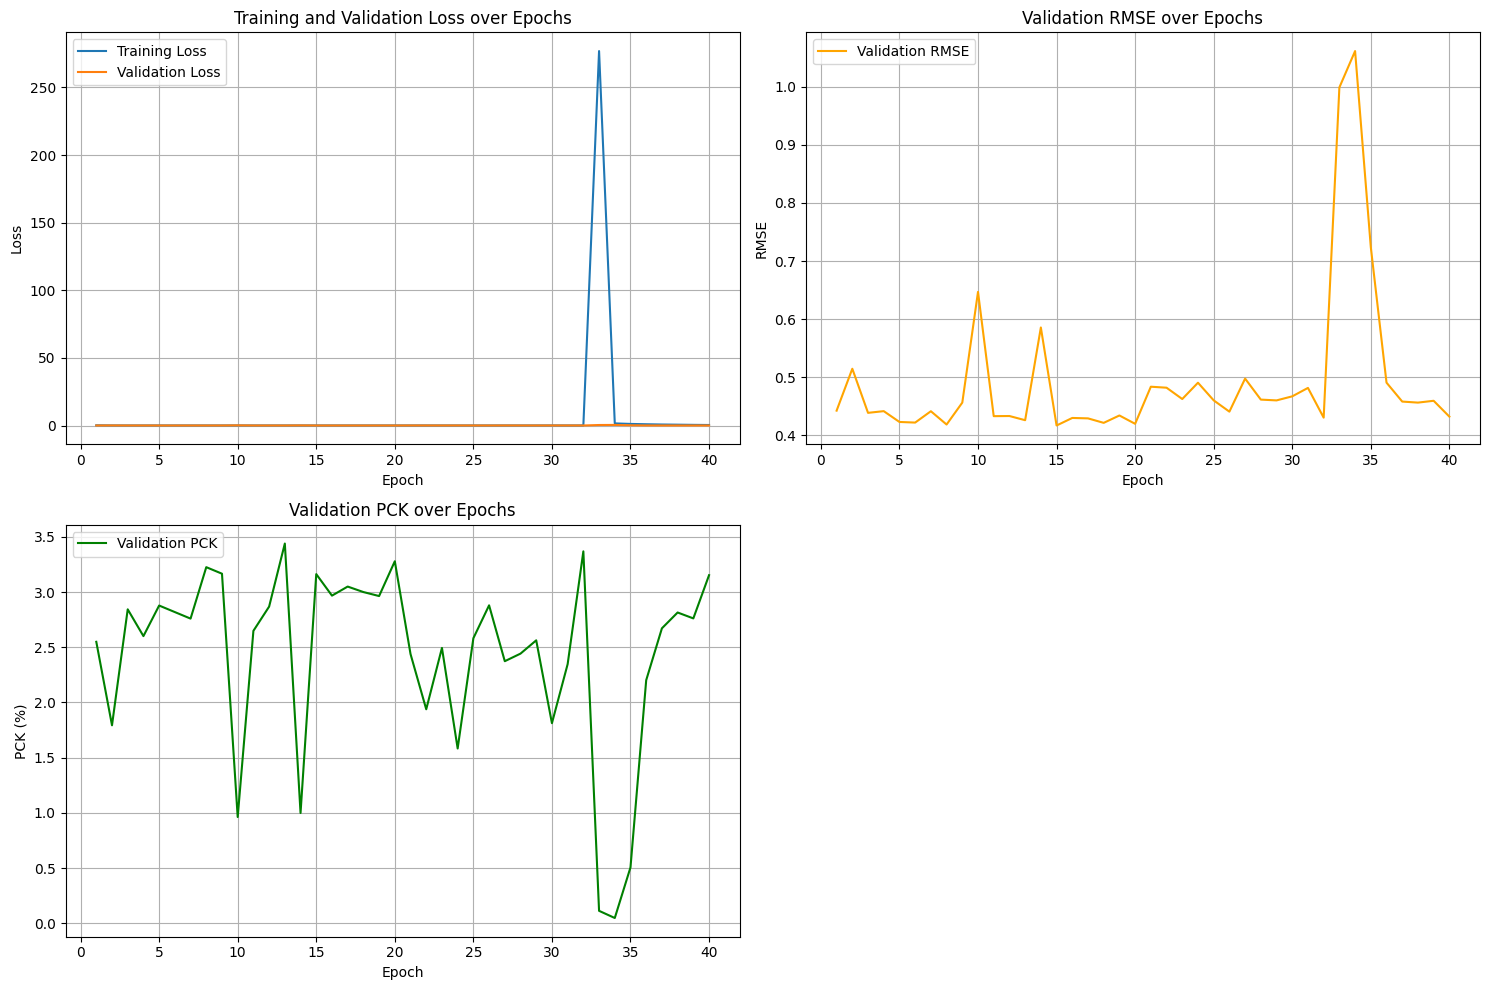

In [ ]:
import matplotlib.pyplot as plt

# Plotting the metrics

plt.figure(figsize=(15, 10))

# Plot Training and Validation Loss
plt.subplot(2, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)

# Plot Validation RMSE
plt.subplot(2, 2, 2)
plt.plot(range(1, len(valid_rmses) + 1), valid_rmses, label='Validation RMSE', color='orange')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Validation RMSE over Epochs')
plt.legend()
plt.grid(True)

# Plot Validation PCK
plt.subplot(2, 2, 3)
plt.plot(range(1, len(valid_pcks) + 1), valid_pcks, label='Validation PCK', color='green')
plt.xlabel('Epoch')
plt.ylabel('PCK (%)')
plt.title('Validation PCK over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [ ]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


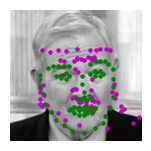

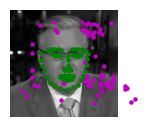

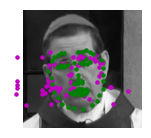

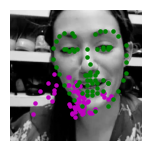

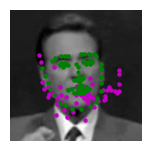

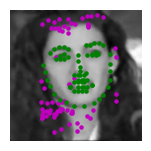

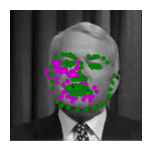

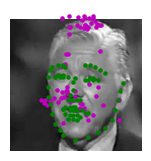

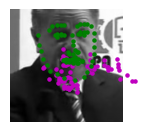

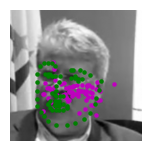

In [ ]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


In [ ]:
import os

# Define the model directory in Google Drive
model_dir = '/content/gdrive/MyDrive/saved_models/'
model_name = 'keypoints_model_MediumNet.pt'

# Create the directory if it does not exist
os.makedirs(model_dir, exist_ok=True)

# After training, save your model parameters in the 'saved_models' directory
torch.save(net.state_dict(), os.path.join(model_dir, model_name))

Once you've found a good model (or two), save your model so you can load it and use it later!

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: write your answer here (double click to edit this cell)

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: write your answer here

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: write your answer here

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.16623642 -0.08630377  0.11059443  0.17592299  0.1112775 ]
 [-0.15406245  0.20427807  0.16771747  0.06175197  0.1188006 ]
 [ 0.13847445 -0.15729816 -0.06465346 -0.146734    0.04163246]
 [-0.15731785 -0.02357356 -0.0502315   0.01706439  0.08905209]
 [ 0.19797607  0.20022567  0.06036212  0.08619145 -0.02512296]]
(5, 5)


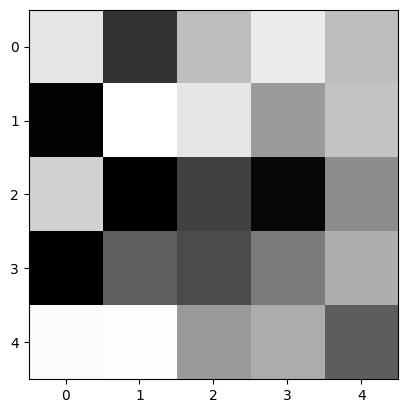

In [ ]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in its convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='https://github.com/pradhapmoorthi/P1_Facial_Keypoints/blob/master/images/feature_map_ex.png?raw=1' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

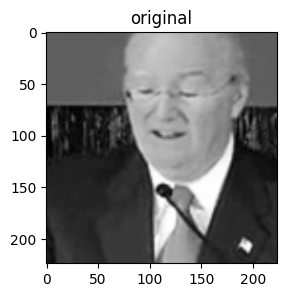

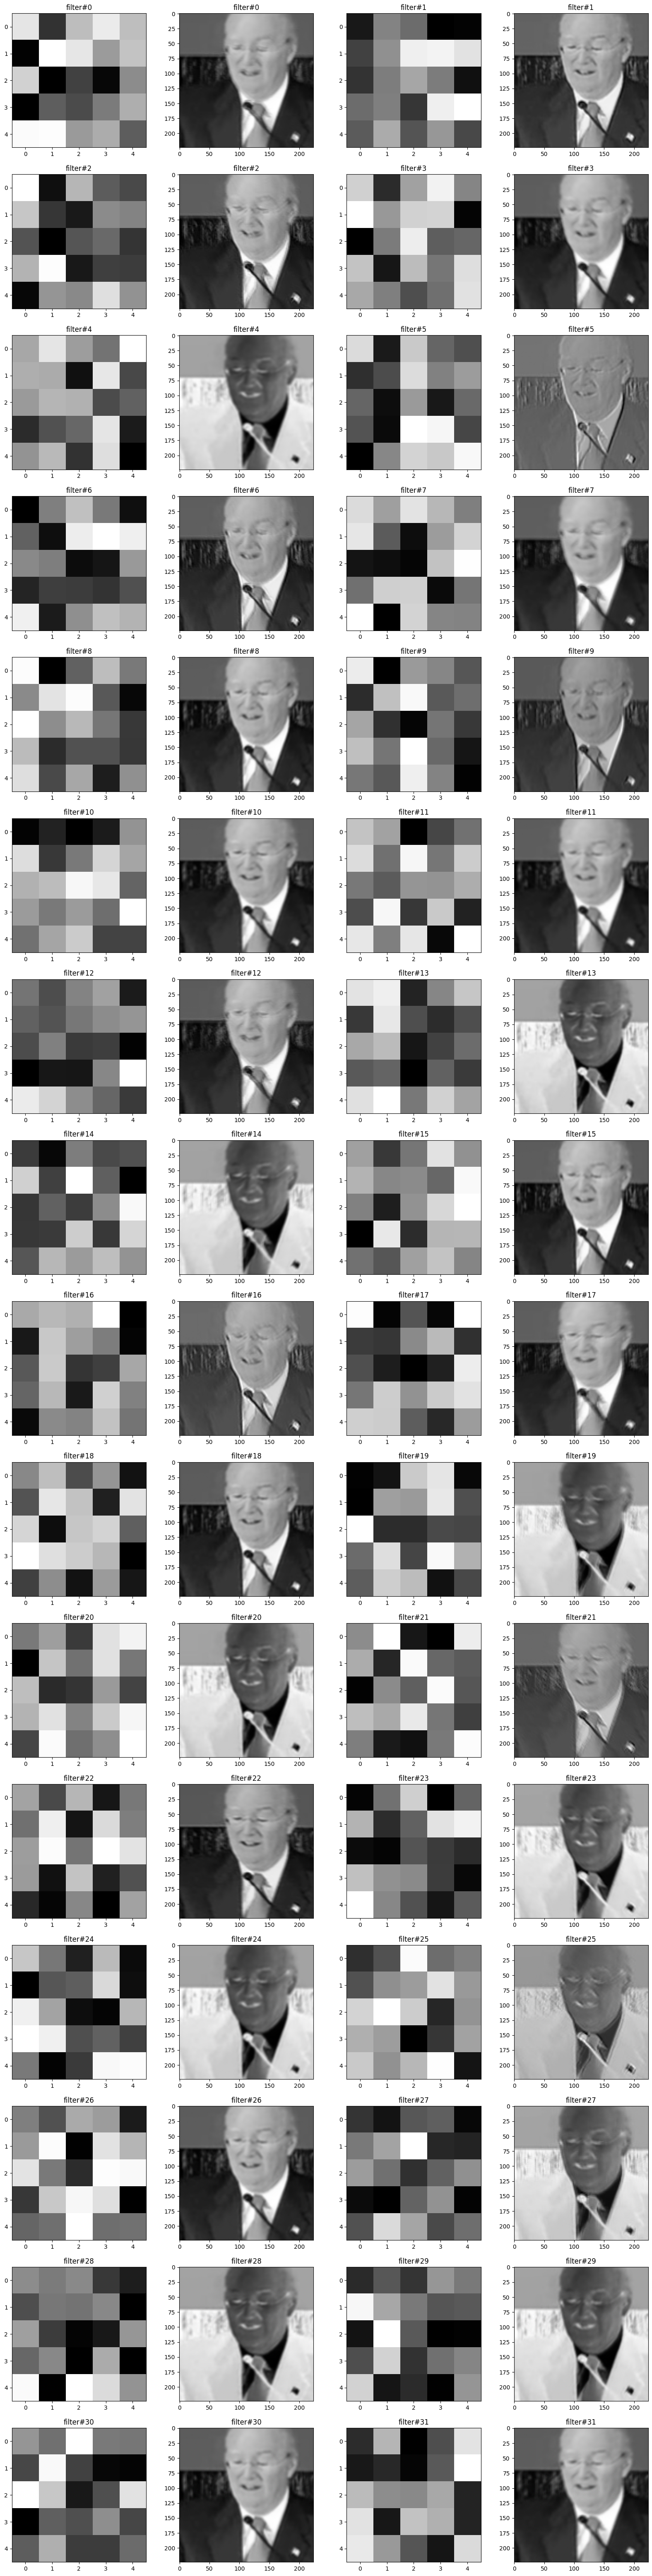

In [ ]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
##TODO: load in and display any image from the transformed test dataset
import random, cv2
sample_index = random.randint(0,len(test_dataset))
sample = test_dataset[sample_index]['image'].data
sample = sample.numpy()
sample = np.transpose(sample, (1,2,0))
sample = np.squeeze(sample)
plt.figure(figsize=(7,3))
plt.imshow(sample, cmap='gray')
plt.title('original')
plt.figure(figsize=(20,80))
## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
for filter_index in range(32*2):
    plt.subplot(16,4,filter_index+1)
    if filter_index%2==0:
        plt.imshow(w[int(filter_index/2)][0], cmap='gray')
    else:
        c=cv2.filter2D(sample,-1,w[int((filter_index-1)/2)][0])
        plt.imshow(c, cmap='gray')
    plt.title('filter#'+str(int(np.floor(filter_index/2))))
plt.show()

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: (does it detect vertical lines or does it blur out noise, etc.) write your answer here

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!